C:\Users\adakw\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `teval`.
  warn("The following arguments have no effect for a chosen solver: {}."


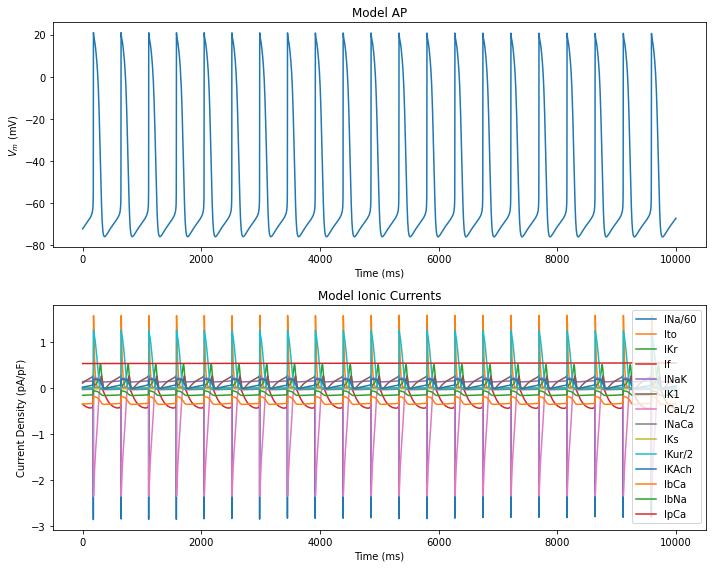


Metrics_____________________
APD_50s:  104.22822378642861
APD_75s:  125.88152853131619
APD_90s:  143.64022110946385
CLs:  470.24101428683963
MDPs:  -75.90899552667898
Average BPM:  126.0




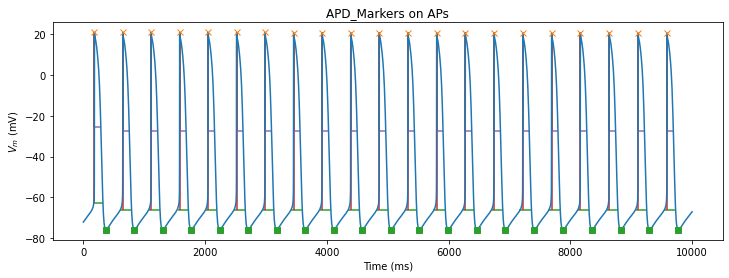

In [1]:
#Description: Akwaboah AD, Tsevi B, Yamlome P, Treat JA, Brucal-Hallare M, 
#Cordeiro JM and Deo M (2021) An in silico hiPSC-Derived Cardiomyocyte Model Built
#With Genetic Algorithm. Front. Physiol. 12:675867. doi: 10.3389/fphys.2021.675867
#Date: 03/11/2020
#Last Revised: 03/24/2021 (Akwasi D. Akwaboah)

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import peak_widths, find_peaks

#Scaling coefficients - Ionic Currents Maximal Conductances
K_INa = 1  #1
K_Ito = 0.75  #2
K_IKr = 1.25 #3
K_If = 0.91    #4
K_ICaL = 1.1  #5
K_IKur = 0.8     #6
K_IKs = 0.3   #7
K_INaK = 1.7    #8
K_INaCa = 1    #9
K_IK1 = 0.18   #10
K_IKAch = 1    #11
K_IbNa = 1.6 #12
K_IbCa = 1.6  #13
K_IpCa = 5.2    #14

#Constants___________________________________
#time Span
dt = 0.001
tSpan = (0, 10000) #ms
tEval = np.arange(tSpan[0], tSpan[1], dt) #Time stamps for ODE solver
R = 8.3143 #J/(K.mol)
T = 310 #K
F = 96.4867 #C/mmol
Cm = 100 #pF; average capacitance for INa
Et = (R*T)/F

#ICaL and Ca_i constants
#Ca_i constants
IpCa_max = 0.275 #pA/pF
Prel = 5*10.0 #ms-1 SR maximal release rate constant
Krel = 0.0012
Pup = 1.5*0.005 #0.005 #mM/ms maximal uptake rate constant
Kup = 0.0006#mM half-maximal Ca_up
tau_difCa = 0.04 #ms
tau_tr = 55*0.5 #ms

#Ca Buffering
Mg_i = 2.5 # intracellular Magnesium - used in buffering
k_ftc = 88.8
k_btmm = 0.751
k_btmc = 0.00751
k_bcq = 0.445
k_bcm = 0.542
k_fcm = 227.7
k_fcq = 0.534
k_ftmm = 2.277
k_ftmc = 227.7
k_btc = 0.446
TMC_tot = 0.062
TC_tot = 0.031
CM_tot = 0.045
CQ_tot = 10
K_mfca = 0.00035
alpha_fca = 0.035

Na_o = 140 #mM
Ca_o = 2 #mM

Vcell = 20100.0 #um^3 converted from 3pl ie. 1000
V_sub = 0.01*Vcell
V_up = 0.0116*Vcell
Vi = 0.46*(Vcell - V_sub)
Vrel = 0.0012*Vcell

#IKs
G_ks = 0.129 #nS/pF

#IKur
IKur_prm = np.array([0.005, 0.05, 15, 13, 0.65, 10, 8.5, 30, 59, 0.65, 2.5, 82, 17,
                     30.3, 9.6, 21, 185, 28, 1, 158, 16, 99.45, 27.48])
K_q10 = 3
K_o = 5.4
gKAch = 0.0011*np.power(K_o, 0.41)

#INaK
INaK_max = 4.3 #pA/pF
K_mNai = 87.5 #mM Nai half-saturation constant
K_mKo = 1 #mM Ki half-saturation constant

#INaCa
gamma_NaCa = 0.35
k_sat = 0.1
K_mCa = 1.38 #mM half-saturation constant
K_mNa = 10 #mM
INaCa_max = 100 #pA/pF

#Background currents
G_bCa = 0.00113
G_bNa = 0.000674
G_bK = 0.000674
gK1 = 0.09 #nS/pF

INa_par = np.array([1.01872382e+01, 2.81165049e-01, 4.11026646e-02, 1.85913230e-01,
       2.33559087e+00, 2.69343146e+05, 9.44262616e+04, 1.95789481e-01,
       4.34129546e-05, 5.95815316e-02, 4.29535950e-01, 1.26055107e-01,
       5.45387213e-03, 1.11372808e-01, 8.23823189e-01, 7.98343615e+00,
       4.37170307e-01, 2.87045755e-07, 2.42211297e-02, 5.22647290e+01])
Ito_par = np.array([1.07795129e-03, 1.55692740e-01, 1.46825076e+01, 1.59100592e+01,
       3.83118368e+00, 4.80328534e+01, 4.89599981e+01, 2.85524250e-01,
       1.23540497e+02, 5.03128630e+01, 3.16319213e+02, 1.32886316e+01,
       4.13205093e+00, 2.30054808e+00, 2.67131386e+01, 1.12598680e-01,
       1.13596188e+03, 4.95801337e+01, 5.53181883e+00, 1.97135761e+01])
IKr_par = np.array([1.86484701e-02, 6.42652882e+00, 1.18799783e+01, 4.01163188e+01,
       1.40822232e+01, 9.63756681e-01, 4.23722972e-02, 1.70356140e+01,
       1.24135620e-03, 2.33474212e+01, 4.56822754e-03, 1.46185713e+01,
       1.71859133e-04, 1.73714985e+01, 8.47065470e-02, 5.21505971e+01,
       7.59956413e-01, 1.07977148e+02])
If_par = np.array([5.02968027e-02, 7.02798870e-02, 1.68826991e+00, 3.67280874e-02,
       5.17628426e+00, 5.35050858e-02, 4.01031320e+03])

ICaL_par = np.array([ 0.18722844, 1.00592002, 6.38249172, 29.16060561,  3.60776178,  0.09457633])

#initial condition tuple
ini_con = (-72.13392269291998, 0.021232582553136294, 0.8953389405508547, 0.9828395333073615, 10.612071750230232, #---------------old
           91.88105959334906, 0.0042110467813189535, 0.979408089136425, 0.004203096455919421, 0.18607260860356756,
           0.007833508834981354, 0.07751078049183394, 0.9070325229910078, 0.054930836509322276, 1.4345390653496403e-05,
           0.9746917094323123, 0.4540983986303234, 0.05706947461622824, 0.5179947908649024, 0.42582651486832124, 0.11324342208462247,
           0.15020628640302436, 0.005815289107170125, 0.0003039768831025202, 0.00042073428597645955, 
           0.6752811199537715, 0.004874494711477725, 0.06422007766460627, 0.012521015669772591, 0.9694571918864883)

#Stimulus Current, Istim - created incase needed, set to zero since hiPSC-CM has spontaneous activity
def Istim(t, Icm, freq):
    T = 1000/freq
    if abs(t)%T <= T/2:
        return Icm
    else:
        return 0.0 #Monophasic stimulation
    
#function: System of differential equations for ODE solver
def d_all_dt(t, Y):
    Vm = Y[0]
    m = Y[1]
    h = Y[2]
    j = Y[3]
    Na_i = Y[4]
    K_i = Y[5]
    xtof = Y[6]
    ytof = Y[7]
    xtos = Y[8]
    ytos = Y[9]
    paF = Y[10]
    paS = Y[11]
    pi = Y[12]
    yf = Y[13]
    d = Y[14]
    f = Y[15]
    fca = Y[16]
    ftc = Y[17]
    f_tmc = Y[18]
    f_tmm = Y[19]
    f_cmi = Y[20]
    f_cms = Y[21]
    f_cq = Y[22]
    Ca_i = Y[23]
    Ca_sub = Y[24]
    Ca_up = Y[25]
    Ca_rel = Y[26]
    xs = Y[27]
    ua = Y[28]
    ui = Y[29]
    
    
    # INa - Luo-Rudy Formulation (GA Optimized)_______________________________________________________
    # INa formulation - Luo-Rudy

    am = INa_par[1]*(Vm+47.13)/(1-np.exp(-0.1*(Vm+47.13)))
    bm = INa_par[2]*np.exp(-Vm/11)
    
    if (Vm < -40):
        ah = INa_par[3]*np.exp((80+Vm)/-6.8)
        bh = INa_par[4]*np.exp(0.079*(Vm))+INa_par[5]*np.exp(0.35*(Vm))
        aj = (-INa_par[6]*np.exp(INa_par[7]*Vm)-INa_par[8]*np.exp(-INa_par[9]*Vm))*((Vm+37.78)/(1+np.exp(INa_par[10]*(Vm+79.23))))
        bj = (INa_par[11]*np.exp(-INa_par[12]*Vm))/(1+np.exp(-0.1378*(Vm+40.14)))
    else:
        ah = 0
        bh = 1/(INa_par[13]*(1+np.exp((Vm+INa_par[14])/-INa_par[15])))
        aj = 0
        bj = (INa_par[16]*np.exp(-INa_par[17]*Vm))/(1+np.exp(-INa_par[18]*(Vm+INa_par[19])))
        
    taum = 1/(am+bm)
    tauh = 1/(ah+bh)
    tauj = 1/(aj+bj)
    mss = am*taum
    hss = ah*tauh
    jss = aj*tauj

    ENa = (R * T / (F)) * np.log(Na_o / Na_i)
    INa = K_INa*(INa_par[0] * (m**3) * h * j * (Vm - ENa))
    dm_dt = ((mss - m) / taum)
    dh_dt = ((hss - h) / tauh)
    dj_dt = ((jss - j) / tauj)
    
    # Ito - Grandi-Pandit Formulation (GA Optimized) _____________________________________________
    xtoss = 1 / (1 + np.exp(-(Vm - Ito_par[2]) / Ito_par[3]))
    ytoss = 1 / (1 + np.exp((Vm + 41.1) / 6.68))
    #fast Ito
    tau_xf = Ito_par[4]*(np.exp(-((Vm+Ito_par[5])/Ito_par[6])**2)) + Ito_par[7]
    tau_yf = Ito_par[8]*(np.exp(-((Vm+Ito_par[9])**2)/Ito_par[10])) + Ito_par[11]
    dxtof_dt = ((xtoss - xtof)/ tau_xf)
    dytof_dt = ((ytoss - ytof)/ tau_yf)
    EK = (R * T / (F)) * np.log(K_o / K_i)
    Itof = Ito_par[0] * xtof * ytof * (Vm - EK)
    #slow Ito
    tau_xs = Ito_par[12]/(1+np.exp((Vm+Ito_par[13])/Ito_par[14])) + Ito_par[15]
    tau_ys = Ito_par[16]/(1+np.exp((Vm+Ito_par[17])/Ito_par[18])) + Ito_par[19]
    dxtos_dt = ((xtoss - xtos)/ tau_xs)
    dytos_dt = ((ytoss - ytos)/ tau_ys)
    Itos = Ito_par[1] * xtos * ytos * (Vm - EK)
    Ito = K_Ito*(Itof + Itos)  #25% allowable scaling adjustment

    #IKr Kurata Formulation (GA Optimized)_________________________________________________
    pa_ss = 1.0/(1.0 + np.exp(-(Vm + IKr_par[1])/IKr_par[2]))
    pi_ss = 1.0/(1.0 + np.exp((Vm + IKr_par[3])/IKr_par[4]))
    tau_paF = IKr_par[5]/(IKr_par[6]*np.exp(Vm/IKr_par[7]) + IKr_par[8]*np.exp(-Vm/IKr_par[9]))
    tau_paS = IKr_par[5]/(IKr_par[10]*np.exp(Vm/IKr_par[11]) + IKr_par[12]*np.exp(-Vm/IKr_par[13]))
    tau_pi = 1/(IKr_par[14]*np.exp(-Vm/IKr_par[15]) + IKr_par[16]*np.exp(Vm/IKr_par[17]))
    gkr = IKr_par[0]*np.power(K_o, 0.59)
    IKr = K_IKr*gkr*(Vm - EK)*(0.6*paF + 0.4*paS)*pi

    dpaF_dt = ((pa_ss - paF)/tau_paF)
    dpaS_dt = ((pa_ss - paS)/tau_paS)
    dpi_dt = ((pi_ss - pi)/tau_pi)
    
    #If Stewart Formulation (GA Optimized)__________________________________________________
    yss = 1/(1 + np.exp((Vm + 80.6)/6.8))
    alpha_y = np.exp(-(If_par[2] + (If_par[3]*Vm)))
    beta_y = np.exp(If_par[4] + (If_par[5]*Vm))
    tau_y = If_par[6]/(alpha_y + beta_y)
    dyf_dt = ((yss - yf)/ tau_y)

    If_k = K_If*If_par[1] * yf * (Vm - EK)
    If_na = K_If*If_par[0] * yf * (Vm - ENa)
    If = If_k + If_na

    # ICaL Kurata Formulation (GA Fitted)____________________________________________________
    d_ss = 1 / (1 + np.exp(-(Vm + ICaL_par[1]) / ICaL_par[2])) 
    f_ss = 1 / (1 + np.exp((Vm + ICaL_par[3]) / ICaL_par[4])) 
    fca_ss = K_mfca / (K_mfca + Ca_sub)
    alpha_dl = -0.02839 * (Vm + 35) / (np.exp(-(Vm + 35) / 2.5) - 1) - (0.0849 * Vm) / (
                np.exp(-(Vm) / 4.8) - 1.00000001)
    beta_dl = 0.01143 * (Vm - 5) / (np.exp((Vm - 5) / 2.5) - 1)
    tau_d = 1 / (alpha_dl + beta_dl)
    tau_f = 257.1 * np.exp(-((Vm + 32.5) / 13.9)**2) + 44.3
    tau_fca = fca_ss / alpha_fca
    ECaL = 1*(R * T / (2*F)) * np.log(Ca_o / Ca_i) #reduced ECaL to reduce the AP peak value
    ICaL = K_ICaL*ICaL_par[0]*d*f*fca*4*(((Vm-ICaL_par[5])*F)/Et)*(Ca_i*np.exp((2*(Vm-ICaL_par[5]))/Et) - 0.341*Ca_o)/(np.exp((2*(Vm-ICaL_par[5]))/Et) - 1)
    
    dd_dt = ((d_ss-d)/tau_d)
    df_dt = ((f_ss-f)/tau_f)
    dfca_dt = ((fca_ss-fca)/tau_fca)
    
    #IKs Courtemanche Formulation______________________________________________________
    alpha_xs = (4e-5) * (Vm - 19.9) / (1 - np.exp(-(Vm - 19.9)/17))
    beta_xs = (3.5e-5) * (Vm - 19.9) / (np.exp((Vm - 19.9)/9) - 1)
    tau_xs1 = 1 / (2 * (alpha_xs + beta_xs))
    xs_ss = 1 / np.sqrt(1 + np.exp(-(Vm - 19.9) / 12.7))
    dxs_dt = ((xs_ss - xs) / tau_xs1)
    EKs = ((R * T) / F) * np.log((0.01833 * Na_o + K_o) / (0.01833 * Na_i + K_i))
    IKs = K_IKs*G_ks * np.power(xs, 2) * (Vm - EKs)
    
    
    # IKur Courtemanche Formulation___________________________________________________
    gkur = IKur_prm[0] + (IKur_prm[1] / (1 + np.exp(- (Vm - IKur_prm[2]) / IKur_prm[3])))
    alpha_ua = IKur_prm[4] / (
                np.exp(-(Vm + IKur_prm[5]) / IKur_prm[6]) + np.exp((-(Vm - IKur_prm[7]) / IKur_prm[8])))
    beta_ua = IKur_prm[9] / (IKur_prm[10] + np.exp((Vm + IKur_prm[11]) / IKur_prm[12]))
    tau_ua = 1 / (K_q10 * (alpha_ua + beta_ua))
    ua_ss = 1 / (1 + np.exp(-(Vm + IKur_prm[13]) / IKur_prm[14]))
    alpha_ui = 1 / (IKur_prm[15] + np.exp(-(Vm - IKur_prm[16]) / IKur_prm[17]))
    beta_ui = IKur_prm[18] * np.exp((Vm - IKur_prm[19]) / IKur_prm[20])
    tau_ui = 1 / (K_q10 * (alpha_ui + beta_ui))
    ui_ss = 1 / (1 + np.exp((Vm - IKur_prm[21]) / IKur_prm[22]))
    dua_dt = ((ua_ss - ua) / tau_ua)
    dui_dt = ((ui_ss - ui) / tau_ui)
    IKur = K_IKur*gkur * (ua**3) * ui * (Vm - EK)
    
    # INaK Courtemanche Formulation_____________________________________________________
    sigma = (1/7)*(np.exp(Na_o/67.3) - 1)
    f_NaK = 1/(1 + 0.1245*np.exp(-(0.1*(F*Vm))/(R*T)) + 0.0365*sigma*np.exp(-(F*Vm)/(R*T)))
    INaK = K_INaK*INaK_max * f_NaK * (1/(1+np.power(K_mNai/Na_i, 1.5))) * (K_o/(K_o + K_mKo))
    
    #INaCa Courtemanche Formulation______________________________________________________
    INaCa_num = INaCa_max * (np.exp(gamma_NaCa * (F / (R * T)) * Vm) * (Na_i**3) * Ca_o - np.exp(
        (gamma_NaCa - 1) * (F / (R * T)) * Vm) * (Na_o**3) * Ca_i)
    INaCa_den = ((K_mNa**3) + (Na_o**3)) * (K_mCa + Ca_o) * (
                1 + k_sat * (np.exp((gamma_NaCa - 1) * (F / (R * T)) * Vm)))
    INaCa = K_INaCa*(INaCa_num / INaCa_den) #37
    
    #IKAch Kurata Formulation_____________________________________________________________
    IKAch = K_IKAch*gKAch*(K_i - K_o*np.exp(-Vm*F/(R*T)))

    #IK1 Grandi-Pandit Formulation_______________________________________________________________
    aK1 = 1.02 / (1 + np.exp(0.2385 * (Vm - EK - 59.215)))
    bK1 = (0.49124 * np.exp(0.08032 * (Vm + 5.476 - EK)) + np.exp(0.06175 * (Vm - 594.31 - EK))) / (
                1 + np.exp(-0.5143 * (Vm + 4.753 - EK)))
    K1_ss = aK1 / (aK1 + bK1)
    IK1 = K_IK1*0.35 * (np.sqrt(K_o / 5.4)) * K1_ss * (Vm - EK) #35

    #Background currents - Courtemanche___________________________________________________________
    IbCa = K_IbCa*G_bCa * (Vm - ECaL)
    IbNa = K_IbNa*G_bNa * (Vm - ENa)
    
    
    #Ca2+ Pump Pump - maintains Ca_i to physiological levels_____________________________________
    IpCa = K_IpCa*IpCa_max * Ca_i/(0.0005 + Ca_i)
    
    
    #Ca2+ fluxes_______________________________________________________________
    #Ca2+ ion homeostasis
    #Ca Diffusion flux: Extracellular subspace and the intracellular
    jCa_diff = (Ca_sub - Ca_i)/tau_difCa
    
    #Ca handling by the SR - uptake, transfer and release
    jrel = Prel*(Ca_rel - Ca_sub)/(1 + (Krel/Ca_sub)**2) #SR release from JSR
    jup = Pup/(1 + Kup/Ca_i) #SR uptake by NSR
    jtr = (Ca_up - Ca_rel)/tau_tr # transfer from NSR to JSR
    
    #Ca buffering__________________________________
    dftc_dt = (k_ftc*Ca_i*(1 - ftc) - k_btc*ftc)
    dftmc_dt = (k_ftmc*Ca_i*(1 - f_tmc - f_tmm) - k_btmc*f_tmc)
    dftmm_dt = (k_ftmm*Mg_i*(1 - f_tmc - f_tmm) - k_btmm*f_tmm)
    dfcmi_dt = (k_fcm*Ca_i*(1 - f_cmi) - k_bcm*f_cmi)
    dfcms_dt = (k_fcm*Ca_sub*(1 - f_cms) - k_bcm*f_cms)
    dfcq_dt = (k_fcq*Ca_rel*(1 - f_cq) - k_bcq*f_cq)

    #intracellular ion concentrations___________________________________
    dCai_dt = ((jCa_diff*V_sub - jup*V_up)/Vi - (CM_tot*dfcmi_dt + TC_tot*dftc_dt + TMC_tot*dftmc_dt))
    dCasub_dt = (jrel*(Vrel/V_sub) - (ICaL + IpCa + IbCa - 2*INaCa)/(2*F*V_sub) - (jCa_diff + CM_tot*dfcms_dt))
    dCaup_dt = (jup - jtr*(Vrel/V_up))
    dCarel_dt = (jtr - jrel - CQ_tot*dfcq_dt)
    
    #Ion Homeostasis______________________________________________
    #[Na]i
    dNai_dt = -Cm*(3*INaK + 3*INaCa + INa + If_na + IbNa)/(F*Vi) 
    #[K]i
    dKi_dt = Cm*(2*INaK - Ito - IKr - If_k - IK1 - IKs - IKur - IKAch)/(F*Vi)
    
    #Sum of Ionic current density (already capacitance normalized)_________________________________
    I_ion = INa + Ito + IKr + If + INaK + ICaL + INaCa + IbCa + IbNa + IK1 + IKs + IKur + IKAch + IpCa
#     I_ion = ICaL + IKr + Ito + If 
    
    # Action Potential_____________________________________________
    dVm_dt = (-I_ion + Istim(t,0,1)) #Icm = 0, i.e. no stimulus, since intrinsically automatic
    
    return dVm_dt, dm_dt, dh_dt, dj_dt, dNai_dt, dKi_dt, dxtof_dt, dytof_dt, dxtos_dt, dytos_dt, dpaF_dt, dpaS_dt, dpi_dt, dyf_dt, dd_dt, df_dt, dfca_dt, dftc_dt, dftmc_dt, dftmm_dt, dfcmi_dt, dfcms_dt, dfcq_dt, dCai_dt, dCasub_dt, dCaup_dt, dCarel_dt, dxs_dt, dua_dt, dui_dt

#Solvers: 'Radau', 'BDF', 'RK23', 'RK45',‘LSODA’, ‘DOP853’ (Explicit solvers are slower)
#Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
sol = solve_ivp(d_all_dt, tSpan, ini_con, teval = tEval, method='Radau')  

time = sol.t
Vmem = sol.y[0]

#Fetch solver ouptut
m = sol.y[1]
h = sol.y[2]
j = sol.y[3]
Na_i = sol.y[4]
K_i = sol.y[5]
xtof = sol.y[6]
ytof = sol.y[7]
xtos = sol.y[8]
ytos = sol.y[9]
paF = sol.y[10]
paS = sol.y[11]
pi = sol.y[12]
yf = sol.y[13]
d = sol.y[14]
f = sol.y[15]
fca = sol.y[16]
ftc = sol.y[17]
f_tmc = sol.y[18]
f_tmm = sol.y[19]
f_cmi = sol.y[20]
f_cms = sol.y[21]
f_cq = sol.y[22]
Ca_i = sol.y[23]
Ca_sub = sol.y[24]
Ca_up = sol.y[25]
Ca_rel = sol.y[26]
xs = sol.y[27]
ua = sol.y[28]
ui = sol.y[29]

#compute AP and currents using solver outputs
ENa = Et * np.log(Na_o / Na_i)
EK = Et * np.log(K_o / K_i)
EKs = ((R * T) / F) * np.log((0.01833 * Na_o + K_o) / (0.01833 * Na_i + K_i))
sigma = (1/7)*(np.exp(Na_o/67.3) - 1)
f_NaK = 1/(1 + 0.1245*np.exp(-(0.1*F*Vmem)/(R*T)) + 0.0365*sigma*np.exp(-(F*Vmem)/(R*T)))
INaCa_num = INaCa_max * (np.exp(gamma_NaCa * (F / (R * T)) * Vmem) * (Na_i**3) * Ca_o - np.exp(
    (gamma_NaCa - 1) * (F / (R * T)) * Vmem) * (Na_o**3) * Ca_i)
INaCa_den = ((K_mNa**3) + (Na_o**3)) * (K_mCa + Ca_o) * (
            1 + k_sat * (np.exp((gamma_NaCa - 1) * (F / (R * T)) * Vmem)))
aK1 = 1.02 / (1 + np.exp(0.2385 * (Vmem - EK - 59.215)))
bK1 = (0.49124 * np.exp(0.08032 * (Vmem + 5.476 - EK)) + np.exp(0.06175 * (Vmem - 594.31 - EK))) / (
            1 + np.exp(-0.5143 * (Vmem + 4.753 - EK)))
K1_ss = aK1 / (aK1 + bK1)
gkur = IKur_prm[0] + (IKur_prm[1] / (1 + np.exp(- (Vmem - IKur_prm[2]) / IKur_prm[3])))
gkr = IKr_par[0]*np.power(K_o, 0.59)
ECaL = 1*(R * T / (2*F)) * np.log(Ca_o / Ca_i) #scaling ICaL to reduce the AP peaks
    
INa = K_INa*INa_par[0]*(m**3)*h*j * (Vmem - ENa)
Itof = Ito_par[0] * xtof * ytof * (Vmem - EK)
Itos = Ito_par[1] * xtos * ytos * (Vmem - EK)
Ito = K_Ito*(Itof + Itos)

IKr = K_IKr*gkr*(Vmem - EK)*(0.6*paF + 0.4*paS)*pi
if_k = K_If*If_par[1] * yf * (Vmem - EK)
if_na = K_If*If_par[0] * yf * (Vmem - ENa)
If = if_k + if_na
INaK = K_INaK*INaK_max * f_NaK * (1/(1+np.power(K_mNai/Na_i, 1.5))) * (K_o/(K_o + K_mKo))
# ICaL = K_ICaL*ICaL_par[0]*d*f*fca*(Vmem - ECaL)
ICaL = K_ICaL*ICaL_par[0]*d*f*fca*4*(((Vmem-ICaL_par[5])*F)/Et)*(Ca_i*np.exp((2*(Vmem-ICaL_par[5]))/Et) - 0.341*Ca_o)/(np.exp((2*(Vmem-ICaL_par[5]))/Et) - 1)
INaCa = (INaCa_num / INaCa_den)
IK1 = K_IK1*0.35 * K1_ss * (Vmem - EK)
IKs = K_IKs*G_ks*(sol.y[23]**2)*(Vmem - EKs)
IKur = K_IKur*gkur*(ua**3) * ui * (Vmem - EK)
IKAch = K_IKAch*gKAch*(K_i - K_o*np.exp(-Vmem*F/(R*T)))
IbCa = K_IbCa*G_bCa * (Vmem - ECaL)
IbNa = K_IbNa*G_bNa * (Vmem - ENa)
IpCa = K_IpCa*IpCa_max * Ca_i/(0.0005 + Ca_i)

#Ca fluxes
jrel = Prel*(Ca_rel - Ca_sub)/(1 + (Krel/Ca_sub)**2) #SR release from JSR
jup = Pup/(1 + Kup/Ca_i) #SR uptake by NSR
jtr = (Ca_up - Ca_rel)/tau_tr # transfer from NSR to JSR
jCa_diff = (Ca_sub - Ca_i)/tau_difCa

sx = 0
Vmx = Vmem[sx:]
tmx = time[sx:]
peaks, _ = find_peaks(Vmx,distance=50)
valleys, _ = find_peaks(-Vmx,distance=50)
# peaks, _ = find_peaks(Vmx)
# valleys, _ = find_peaks(-Vmx)
# peaks, _ = find_peaks(Vmx,distance=50)
# valleys, _ = find_peaks(-Vmx,distance=50)
# print(peaks)
t_pks = tmx[peaks]
V_pks = Vmx[peaks]

t_vlys = tmx[valleys]
V_vlys = Vmx[valleys]

#APD90
APD90 = peak_widths(Vmx, peaks, rel_height=0.9)
V_min = APD90[1]
peaks_indx_arr = APD90[2:]
pks_indx_int = np.uint16(np.around(peaks_indx_arr))
pks_times = time[pks_indx_int]
APD90_hl_arr = np.zeros((3, len(peaks)))
APD90_hl_arr[0] = APD90[1]
APD90_hl_arr[1:] = pks_times
APD90_vl_arr = np.zeros((3, len(peaks)))
APD90_vl_arr[0] = t_pks
APD90_vl_arr[1] = APD90[1]
APD90_vl_arr[2] = V_pks
APD90s = pks_times[1] - t_pks #actual APDs

#APD75
APD75 = peak_widths(Vmx, peaks, rel_height=0.75)
V_min = APD90[1]
peaks_indx_arr = APD75[2:]
pks_indx_int = np.uint16(np.around(peaks_indx_arr))
pks_times = time[pks_indx_int]
APD75_hl_arr = np.zeros((3, len(peaks)))
APD75_hl_arr[0] = APD75[1]
APD75_hl_arr[1:] = pks_times
APD75_vl_arr = np.zeros((3, len(peaks)))
APD75_vl_arr[0] = t_pks
APD75_vl_arr[1] = APD75[1]
APD75_vl_arr[2] = V_pks
APD75s = pks_times[1] - t_pks #actual APDs

#APD50
APD50 = peak_widths(Vmx, peaks, rel_height=0.5)
V_min = APD90[1]
peaks_indx_arr = APD50[2:]
pks_indx_int = np.uint16(np.around(peaks_indx_arr))
pks_times = time[pks_indx_int]
APD50_hl_arr = np.zeros((3, len(peaks)))
APD50_hl_arr[0] = APD50[1]
APD50_hl_arr[1:] = pks_times
APD50_vl_arr = np.zeros((3, len(peaks)))
APD50_vl_arr[0] = t_pks
APD50_vl_arr[1] = APD50[1]
APD50_vl_arr[2] = V_pks
APD50s = pks_times[1] - t_pks #actual APDs

CLs = np.diff(t_pks)
BPM = len(peaks)/(((time[-1] - time[0])/60000))

plt.figure(figsize = (10,8))
plt.subplot(211)
plt.title('Model AP')
plt.plot(time[sx:], Vmem[sx:], label= 'Model')
plt.xlabel('Time (ms)')
plt.ylabel('$V_m$ (mV)')

plt.subplot(212)
plt.title('Model Ionic Currents')
plt.plot(time[sx:], INa[sx:]/60, label = 'INa/60')
plt.plot(time[sx:], Ito[sx:], label = 'Ito')
plt.plot(time[sx:], IKr[sx:], label = 'IKr')
plt.plot(time[sx:], If[sx:], label = 'If')
plt.plot(time[sx:], INaK[sx:], label = 'INaK')
plt.plot(time[sx:], IK1[sx:], label = 'IK1')
plt.plot(time[sx:], ICaL[sx:]/2, label = 'ICaL/2')
plt.plot(time[sx:], INaCa[sx:], label = 'INaCa')
plt.plot(time[sx:], IKs[sx:], label = 'IKs')
plt.plot(time[sx:], IKur[sx:]/2, label = 'IKur/2')
plt.plot(time[sx:], IKAch[sx:], label = 'IKAch')
plt.plot(time[sx:], IbCa[sx:], label = 'IbCa')
plt.plot(time[sx:], IbNa[sx:], label = 'IbNa')
plt.plot(time[sx:], IpCa[sx:], label = 'IpCa')
plt.ylabel('Current Density (pA/pF)')
plt.xlabel('Time (ms)')
plt.legend()
plt.tight_layout()
plt.show()

print('\nMetrics_____________________')
print('APD_50s: ', np.mean(APD50s))
print('APD_75s: ', np.mean(APD75s))
print('APD_90s: ', np.mean(APD90s))
print('CLs: ', np.mean(CLs))
print('MDPs: ', np.mean(V_vlys))
print('Average BPM: ', BPM)
print('\n')

plt.figure(figsize = (12,4))
plt.title('APD_Markers on APs')
plt.plot(tmx, Vmx)
plt.hlines(*APD90_hl_arr, color="C2")
plt.vlines(*APD90_vl_arr, color="C3")
plt.hlines(*APD50_hl_arr, color="C4")
plt.vlines(*APD50_vl_arr, color="C5")
plt.plot(t_pks, V_pks, 'x')
plt.plot(t_vlys, V_vlys, 's')
plt.xlabel('Time (ms)')
plt.ylabel('$V_m$ (mV)')
plt.show()

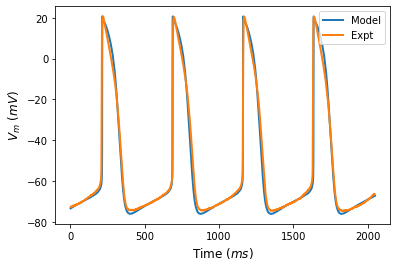

In [2]:
#Experimental vs Model (Run this cell after running the previous cell)
import pandas as pd

B = pd.read_csv('Expt_Control_AP.txt', delim_whitespace=True)
time_exp = B['Time (ms)']
Vm_exp = B['Trace #1']

sx = 1484 # model plot start for start-point alignment
# sx = 10000
plt.plot(time[sx:]-7950, Vmem[sx:], label= 'Model', linewidth=2) #-7950 offset for alignment
plt.plot(time_exp[3440:7530]-1718, Vm_exp[3440:7530], label= 'Expt', linewidth=2)
plt.xlabel('Time $(ms)$', fontsize = 12)
plt.ylabel('$V_m\ (mV)$', fontsize = 12)
# plt.xlim(-100, 2350)
plt.legend(loc='upper right')
plt.show()